#👩‍🎤🤘 Music Generator: LSTM 👩‍🎤🤘

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt 
import tensorflow 
import numpy as np 
import pandas as pd 
import music21
import random
import IPython
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tensorflow.keras.backend as K
import os
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)
from tensorflow.keras.optimizers import Adamax
from IPython.display import Image, Audio
from collections import Counter
from music21 import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
#Loading the list of chopin's midi files as stream 
path = "/content/drive/MyDrive/ds.nn/Classical Music MIDI/chopin/"
#Getting midi files
midies= []
for i in os.listdir(path):
    if i.endswith(".mid"):
        k = path+i
        midi = converter.parse(k)
        midies.append(midi)

In [ ]:
midies

[<music21.stream.Score 0x7f22d045e750>,
 <music21.stream.Score 0x7f22d18b5950>,
 <music21.stream.Score 0x7f22d11db850>,
 <music21.stream.Score 0x7f22d1823c50>,
 <music21.stream.Score 0x7f22ce497b90>,
 <music21.stream.Score 0x7f22ce5a1f90>,
 <music21.stream.Score 0x7f22cd4202d0>,
 <music21.stream.Score 0x7f22cd345150>,
 <music21.stream.Score 0x7f22cdc2cc10>,
 <music21.stream.Score 0x7f22cec3b310>,
 <music21.stream.Score 0x7f22ceccc150>,
 <music21.stream.Score 0x7f22cef030d0>,
 <music21.stream.Score 0x7f22ce846650>,
 <music21.stream.Score 0x7f22cc9461d0>,
 <music21.stream.Score 0x7f22c8d01ed0>,
 <music21.stream.Score 0x7f22c8861bd0>,
 <music21.stream.Score 0x7f22cec32350>,
 <music21.stream.Score 0x7f22cc21e3d0>,
 <music21.stream.Score 0x7f22c74027d0>,
 <music21.stream.Score 0x7f22caa19050>,
 <music21.stream.Score 0x7f22cd77dd90>,
 <music21.stream.Score 0x7f22f9523d50>,
 <music21.stream.Score 0x7f22cb067190>,
 <music21.stream.Score 0x7f22c3e00cd0>,
 <music21.stream.Score 0x7f22c36027d0>,


In [ ]:
seq_lenght = 40
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        # instrument is a method from music21
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))
    return notes


def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi


In [ ]:
Corpus= extract_notes(midies)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 63429


# Creating a count dictionary (count of every note)


In [ ]:
number = Counter(Corpus)
print("Total unique notes in the Corpus:", len(number))

Total unique notes in the Corpus: 317


In [ ]:
number

Counter({'0': 321,
         '0.1': 14,
         '0.2': 12,
         '0.2.5': 8,
         '0.2.6': 29,
         '0.2.6.8': 4,
         '0.2.7': 1,
         '0.3': 259,
         '0.3.5': 68,
         '0.3.6': 52,
         '0.3.6.8': 6,
         '0.3.6.9': 6,
         '0.3.7': 75,
         '0.4': 185,
         '0.4.5': 1,
         '0.4.6': 10,
         '0.4.7': 34,
         '0.4.8': 4,
         '0.5': 178,
         '0.5.6': 13,
         '0.6': 128,
         '1': 437,
         '1.2': 3,
         '1.2.4.8': 3,
         '1.3': 31,
         '1.3.5.9': 4,
         '1.3.6': 34,
         '1.3.7': 53,
         '1.3.8': 7,
         '1.4': 129,
         '1.4.5': 1,
         '1.4.6': 2,
         '1.4.7': 15,
         '1.4.7.10': 6,
         '1.4.7.9': 2,
         '1.4.8': 16,
         '1.5': 304,
         '1.5.7': 1,
         '1.5.8': 97,
         '1.5.9': 5,
         '1.6': 349,
         '1.7': 119,
         '10': 413,
         '10.0': 15,
         '10.0.3': 3,
         '10.0.3.6': 32,
         '10

# Removing rare notes

In [ ]:
rare= []
for index, (key, value) in enumerate(number.items()):
    if value < 100:
        k_note =  key #note
        rare.append(k_note)
for i in Corpus:
    if i in rare:
        Corpus.remove(i)

print("Length of Corpus after elemination the rare notes:", len(Corpus))        
print("Total number of notes that occur less than 100 times:", len(rare))

Length of Corpus after elemination the rare notes: 59853
Total number of notes that occur less than 100 times: 200


# Encoding & Decoding notes

In [ ]:
# Storing all the unique notes
symbol = sorted(list(set(Corpus)))
Len_corpus = len(Corpus) 
Len_symbol = len(symbol) 
mapping = dict((c, i) for i, c in enumerate(symbol))
reverse_mapping = dict((i, c) for i, c in enumerate(symbol))

print("Total number of characters:", Len_corpus)
print("Number of unique characters:", Len_symbol)

Total number of characters: 59853
Number of unique characters: 228


In [ ]:
mapping

{'0': 0,
 '0.2': 1,
 '0.2.5': 2,
 '0.2.6': 3,
 '0.2.6.8': 4,
 '0.3': 5,
 '0.3.5': 6,
 '0.3.6': 7,
 '0.3.6.8': 8,
 '0.3.7': 9,
 '0.4': 10,
 '0.4.6': 11,
 '0.4.7': 12,
 '0.5': 13,
 '0.6': 14,
 '1': 15,
 '1.2.4.8': 16,
 '1.3': 17,
 '1.3.7': 18,
 '1.4': 19,
 '1.4.6': 20,
 '1.4.7': 21,
 '1.5': 22,
 '1.5.8': 23,
 '1.6': 24,
 '1.7': 25,
 '10': 26,
 '10.0': 27,
 '10.0.3.6': 28,
 '10.0.4': 29,
 '10.1': 30,
 '10.1.3': 31,
 '10.1.4': 32,
 '10.1.5': 33,
 '10.2': 34,
 '10.2.5': 35,
 '10.3': 36,
 '11': 37,
 '11.0.4': 38,
 '11.1': 39,
 '11.1.5': 40,
 '11.1.6': 41,
 '11.2': 42,
 '11.2.4': 43,
 '11.2.5': 44,
 '11.2.6': 45,
 '11.3': 46,
 '11.3.6': 47,
 '11.4': 48,
 '2': 49,
 '2.3': 50,
 '2.4': 51,
 '2.4.7': 52,
 '2.4.8': 53,
 '2.5': 54,
 '2.5.7': 55,
 '2.5.8': 56,
 '2.5.9': 57,
 '2.6': 58,
 '2.6.9': 59,
 '2.7': 60,
 '2.8': 61,
 '3': 62,
 '3.4': 63,
 '3.5': 64,
 '3.5.10': 65,
 '3.5.8': 66,
 '3.5.8.11': 67,
 '3.5.9': 68,
 '3.6': 69,
 '3.6.10': 70,
 '3.6.9': 71,
 '3.7': 72,
 '3.7.10': 73,
 '3.8': 74,
 '3.9

In [ ]:
reverse_mapping

{0: '0',
 1: '0.2',
 2: '0.2.5',
 3: '0.2.6',
 4: '0.2.6.8',
 5: '0.3',
 6: '0.3.5',
 7: '0.3.6',
 8: '0.3.6.8',
 9: '0.3.7',
 10: '0.4',
 11: '0.4.6',
 12: '0.4.7',
 13: '0.5',
 14: '0.6',
 15: '1',
 16: '1.2.4.8',
 17: '1.3',
 18: '1.3.7',
 19: '1.4',
 20: '1.4.6',
 21: '1.4.7',
 22: '1.5',
 23: '1.5.8',
 24: '1.6',
 25: '1.7',
 26: '10',
 27: '10.0',
 28: '10.0.3.6',
 29: '10.0.4',
 30: '10.1',
 31: '10.1.3',
 32: '10.1.4',
 33: '10.1.5',
 34: '10.2',
 35: '10.2.5',
 36: '10.3',
 37: '11',
 38: '11.0.4',
 39: '11.1',
 40: '11.1.5',
 41: '11.1.6',
 42: '11.2',
 43: '11.2.4',
 44: '11.2.5',
 45: '11.2.6',
 46: '11.3',
 47: '11.3.6',
 48: '11.4',
 49: '2',
 50: '2.3',
 51: '2.4',
 52: '2.4.7',
 53: '2.4.8',
 54: '2.5',
 55: '2.5.7',
 56: '2.5.8',
 57: '2.5.9',
 58: '2.6',
 59: '2.6.9',
 60: '2.7',
 61: '2.8',
 62: '3',
 63: '3.4',
 64: '3.5',
 65: '3.5.10',
 66: '3.5.8',
 67: '3.5.8.11',
 68: '3.5.9',
 69: '3.6',
 70: '3.6.10',
 71: '3.6.9',
 72: '3.7',
 73: '3.7.10',
 74: '3.8',
 75: 

In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
x = []
y = []
for i in range(0, Len_corpus - length, 1):
    x_ = Corpus[i:i + length]
    class_ = Corpus[i + length]
    x.append([mapping[j] for j in x_])
    y.append(mapping[class_])
Len_y = len(y)
print("Total number of sequences in the Corpus:", Len_y)

Total number of sequences in the Corpus: 59813


# One hot

In [ ]:
X = (np.reshape(x, (Len_y, length, 1)))/ float(Len_symbol)  # reshape X and normalize
Y = tensorflow.keras.utils.to_categorical(y)  # one hot

In [ ]:
print(X.shape)
print(Y.shape)

(59813, 40, 1)
(59813, 228)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

 model

In [ ]:
model = Sequential()
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dense(Y.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 228)               58596     
                                                                 
Total params: 1,964,516
Trainable params: 1,964,516
Non-trainable params: 0
_________________________________________________________________


# Fitting the model

In [ ]:
Epochs=100
history = model.fit(X_train, y_train, batch_size=256, epochs=Epochs) # It takes 30 min



Epoch 1/100
187/187 [==============================] - 23s 89ms/step - loss: 4.5787
Epoch 2/100
187/187 [==============================] - 16s 87ms/step - loss: 4.4883
Epoch 3/100
187/187 [==============================] - 16s 87ms/step - loss: 4.4371
Epoch 4/100
187/187 [==============================] - 16s 86ms/step - loss: 4.4311
Epoch 5/100
187/187 [==============================] - 16s 86ms/step - loss: 4.4211
Epoch 6/100
187/187 [==============================] - 16s 86ms/step - loss: 4.4151
Epoch 7/100
187/187 [==============================] - 16s 86ms/step - loss: 4.4143
Epoch 8/100
187/187 [==============================] - 16s 88ms/step - loss: 4.4134
Epoch 9/100
187/187 [==============================] - 16s 88ms/step - loss: 4.4096
Epoch 10/100
187/187 [==============================] - 16s 88ms/step - loss: 4.4063
Epoch 11/100
187/187 [==============================] - 16s 88ms/step - loss: 4.4063
Epoch 12/100
187/187 [==============================] - 16s 88ms/step - lo

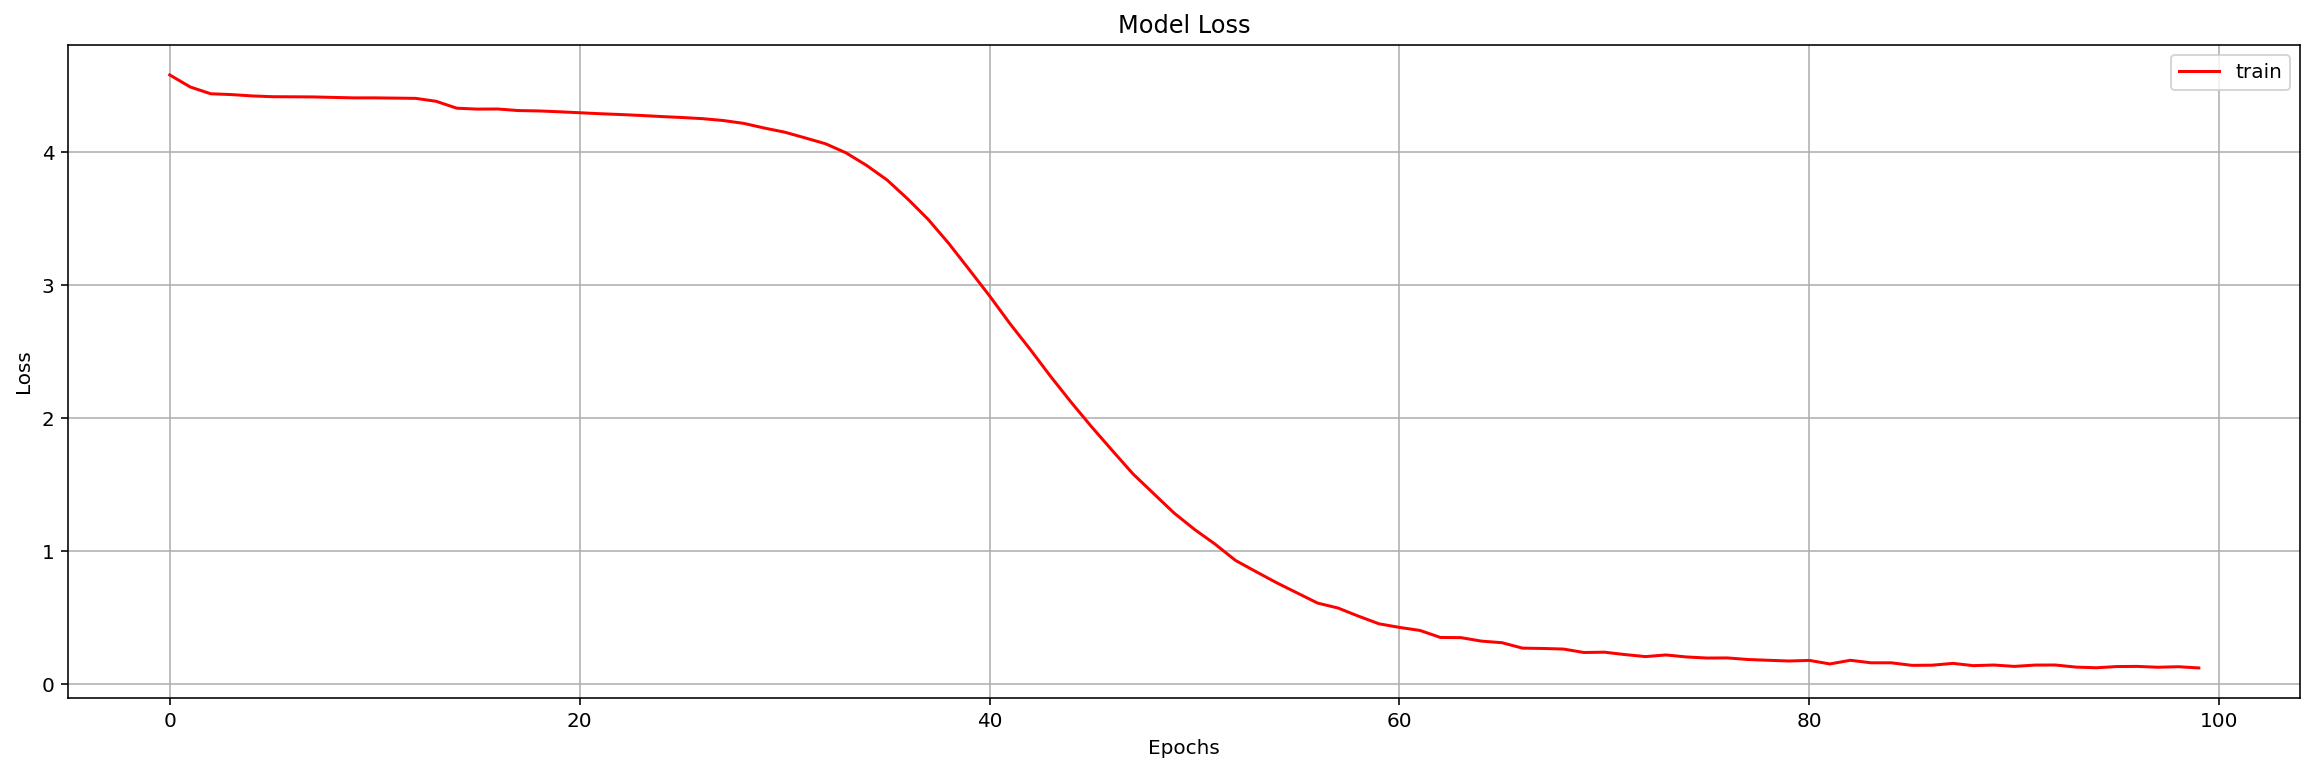

In [ ]:
# Plot the Loss Curves
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'],'r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()


In [ ]:
def Malody_Generator(Note_Count):
    # Note_Count = Count of Notes want to generate
    seed = [np.random.randint(0,len(X_test)-1, seq_lenght)] #sequence_length = 40
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = np.array(seed).reshape(1,seq_lenght,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(Len_symbol)  # Len_symbol is length of total unique characters
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated] # reverse_mapping is a dictionary that maps each number to its related note 
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi

Music_notes, Melody = Malody_Generator(50)
#To save the generated melody
Melody.write('midi','Melody_Generated.mid')

'Melody_Generated.mid'

In [ ]:
IPython.display.Audio("/content/Melody_Generated.mid")


# Dropout(Chopin)

In [ ]:
model2 = Sequential()
model2.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model2.add(Dropout(0.1))
model2.add(LSTM(256))
model2.add(Dense(256))
model2.add(Dropout(0.1))
model2.add(Dense(Y.shape[1], activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer=Adamax(learning_rate=0.01))

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_5 (LSTM)               (None, 256)               787456    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 228)               58596     
                                                                 
Total params: 1,964,516
Trainable params: 1,964,516
No

# Fitting model

In [ ]:
Epochs=100
history2 = model2.fit(X_train, y_train, batch_size=256, epochs=Epochs) # It takes 30 min

Epoch 1/100
187/187 [==============================] - 20s 89ms/step - loss: 4.5497
Epoch 2/100
187/187 [==============================] - 17s 91ms/step - loss: 4.4384
Epoch 3/100
187/187 [==============================] - 17s 90ms/step - loss: 4.4293
Epoch 4/100
187/187 [==============================] - 17s 89ms/step - loss: 4.4250
Epoch 5/100
187/187 [==============================] - 17s 88ms/step - loss: 4.4238
Epoch 6/100
187/187 [==============================] - 16s 88ms/step - loss: 4.4191
Epoch 7/100
187/187 [==============================] - 17s 90ms/step - loss: 4.4206
Epoch 8/100
187/187 [==============================] - 17s 89ms/step - loss: 4.4215
Epoch 9/100
187/187 [==============================] - 17s 90ms/step - loss: 4.4141
Epoch 10/100
187/187 [==============================] - 17s 90ms/step - loss: 4.4120
Epoch 11/100
187/187 [==============================] - 17s 91ms/step - loss: 4.4108
Epoch 12/100
187/187 [==============================] - 17s 89ms/step - lo

# Plotting Loss (Comparing two loss models)

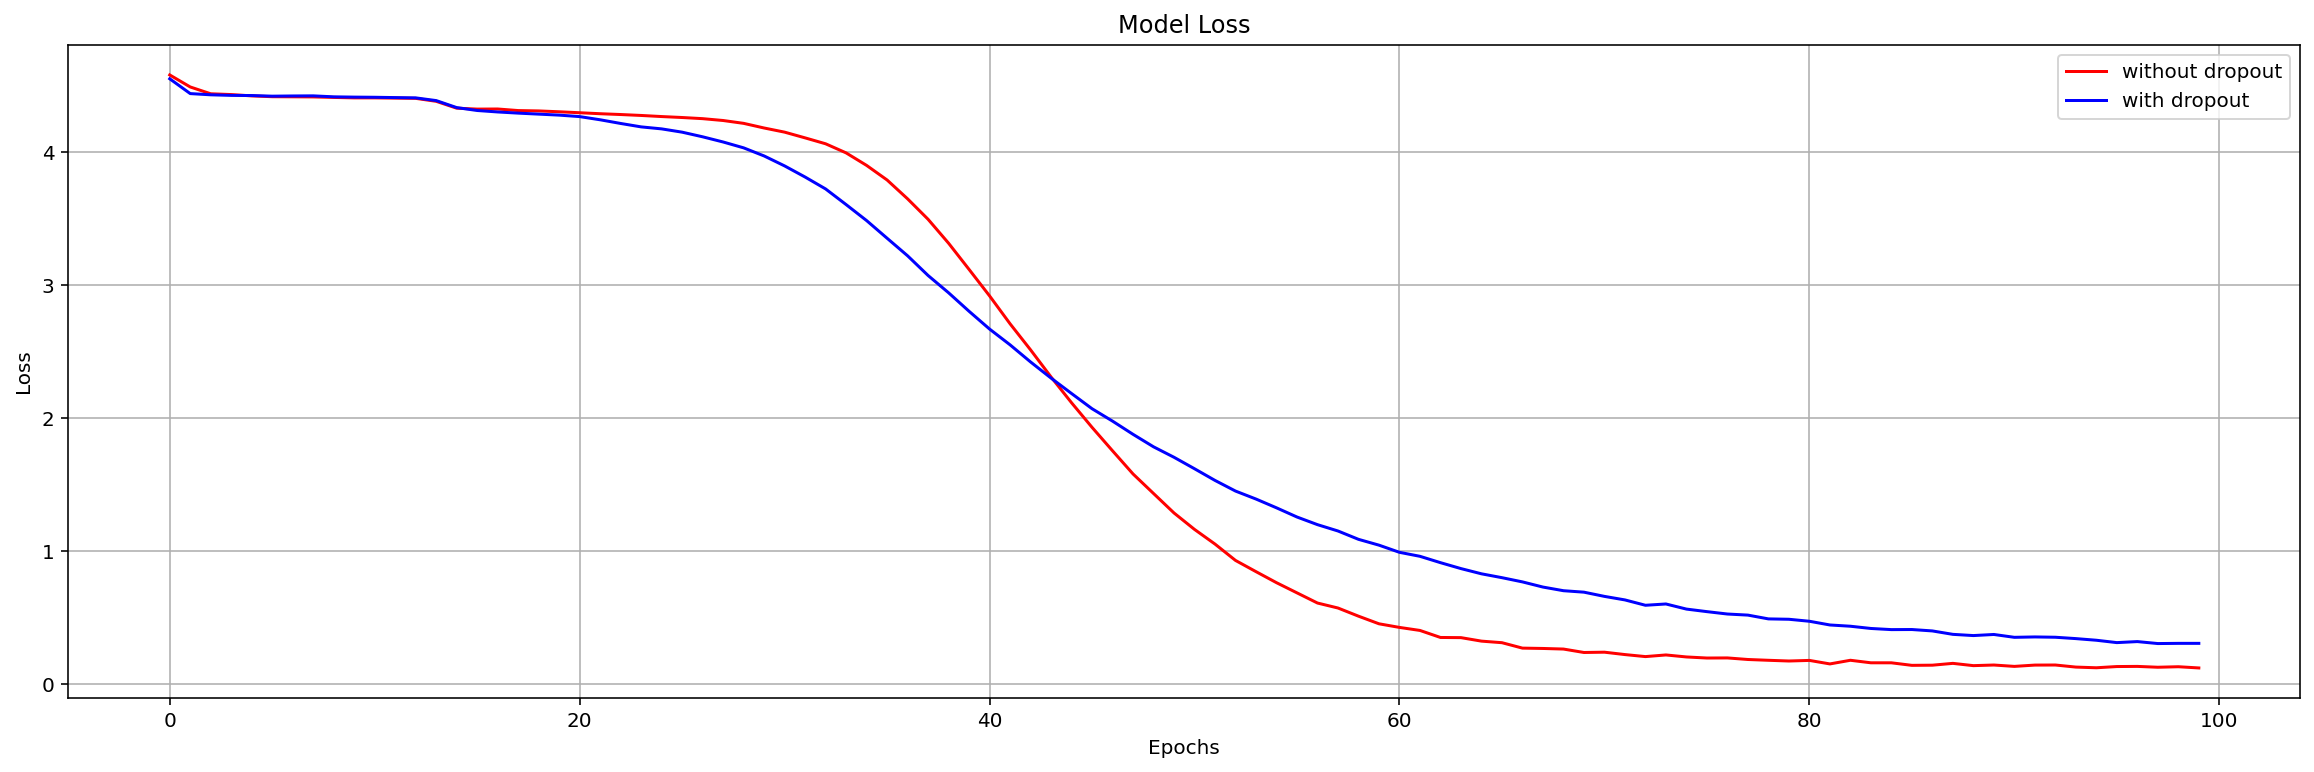

In [ ]:
# Plot the Loss Curves
plt.figure(figsize=(20,6))
plt.plot(history.history['loss'],'r')
plt.plot(history2.history['loss'],'b')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['without dropout', 'with dropout'], loc='upper right')
plt.grid()


# New Melody

In [ ]:
def Malody_Generator_2(Note_Count):
    # Note_Count = Count of Notes want to generate
    seed = [np.random.randint(0,len(X_test)-1, seq_lenght)] #sequence_length = 40
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = np.array(seed).reshape(1,seq_lenght,1)
        prediction = model2.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(Len_symbol)  # L_symb is length of total unique characters
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated] # reverse_mapping is a dictionary that maps each number to its related note 
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi

Music_notes, Melody = Malody_Generator_2(50)
#To save the generated melody
Melody.write('midi','Melody_Generated_.mid')

'Melody_Generated_.mid'

# Mozart

In [ ]:
#Loading the list of chopin's midi files as stream 
path_2 = "/content/drive/MyDrive/ds.nn/Classical Music MIDI/mozart/"
#Getting midi files
midies_2= []
for i in os.listdir(path_2):
    if i.endswith(".mid"):
        k = path_2+i
        midi = converter.parse(k)
        midies_2.append(midi)

In [ ]:
Corpus_2= extract_notes(midies_2)
print("Total notes in all the Mozart midis in the dataset:", len(Corpus_2))

Total notes in all the Mozart midis in the dataset: 59618


In [ ]:
#Creating a count dictionary
number_2 = Counter(Corpus_2)
print("Total unique notes in the Corpus:", len(number_2))

Total unique notes in the Corpus: 197


In [ ]:
#Exploring the notes dictionary
Notes_2 = list(number_2.keys())
Recurrence_2 = list(number_2.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence_2))
print("Most frequent note in Corpus appeared:", max(Recurrence_2), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence_2), "time")
number_2

Average recurrenc for a note in Corpus: 302.6294416243655
Most frequent note in Corpus appeared: 3116 times
Least frequent note in Corpus appeared: 1 time


Counter({'0': 123,
         '0.1': 2,
         '0.2': 32,
         '0.2.6': 12,
         '0.2.7': 1,
         '0.3': 183,
         '0.3.5': 25,
         '0.3.6': 23,
         '0.3.6.9': 6,
         '0.3.7': 6,
         '0.4': 318,
         '0.4.6': 1,
         '0.4.7': 47,
         '0.5': 48,
         '0.6': 1,
         '1': 52,
         '1.2': 8,
         '1.3': 6,
         '1.3.7': 2,
         '1.4': 158,
         '1.4.7': 4,
         '1.4.7.10': 8,
         '1.4.7.9': 1,
         '1.5': 5,
         '1.5.8': 10,
         '1.6': 6,
         '1.7': 21,
         '10': 71,
         '10.0': 97,
         '10.0.3': 3,
         '10.0.4': 19,
         '10.1': 58,
         '10.1.4': 1,
         '10.2': 185,
         '10.2.3': 3,
         '10.2.5': 42,
         '10.3': 45,
         '11': 110,
         '11.0': 17,
         '11.1': 13,
         '11.2': 309,
         '11.2.4': 13,
         '11.2.5': 18,
         '11.2.5.7': 14,
         '11.2.6': 16,
         '11.3': 5,
         '11.3.6': 1,
     

In [ ]:
#Getting a list of rare chords
rare_2= []
for index, (key, value) in enumerate(number_2.items()):
    if value < 100:
        k_note =  key #note
        rare_2.append(k_note)
for i in Corpus_2:
    if i in rare_2:
        Corpus_2.remove(i)

print("Length of Corpus after elemination the rare notes:", len(Corpus_2))        
print("Total number of notes that occur less than 100 times:", len(rare_2))

Length of Corpus after elemination the rare notes: 57248
Total number of notes that occur less than 100 times: 123


In [ ]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symbol_2 = sorted(list(set(Corpus_2)))

Len_corpus_2 = len(Corpus_2) #length of corpus
Len_symbol_2 = len(symbol_2) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symbol_2))
reverse_mapping = dict((i, c) for i, c in enumerate(symbol_2))

print("Total number of characters:", Len_corpus_2)
print("Number of unique characters:", Len_symbol_2)

Total number of characters: 57248
Number of unique characters: 140


In [ ]:
mapping

{'0': 0,
 '0.1': 1,
 '0.2': 2,
 '0.2.6': 3,
 '0.3': 4,
 '0.3.5': 5,
 '0.3.6': 6,
 '0.3.6.9': 7,
 '0.3.7': 8,
 '0.4': 9,
 '0.4.7': 10,
 '1': 11,
 '1.2': 12,
 '1.4': 13,
 '1.5.8': 14,
 '1.7': 15,
 '10': 16,
 '10.0': 17,
 '10.1': 18,
 '10.1.4': 19,
 '10.2': 20,
 '10.2.3': 21,
 '10.2.5': 22,
 '10.3': 23,
 '11': 24,
 '11.0': 25,
 '11.2': 26,
 '11.2.5': 27,
 '11.2.6': 28,
 '2': 29,
 '2.3': 30,
 '2.4': 31,
 '2.4.8': 32,
 '2.5': 33,
 '2.5.8': 34,
 '2.5.9': 35,
 '2.6': 36,
 '2.6.9': 37,
 '2.7': 38,
 '2.8': 39,
 '3': 40,
 '3.5': 41,
 '3.7': 42,
 '4': 43,
 '4.10': 44,
 '4.6': 45,
 '4.7': 46,
 '4.7.10': 47,
 '4.7.9': 48,
 '4.8': 49,
 '4.8.11': 50,
 '4.9': 51,
 '5': 52,
 '5.10': 53,
 '5.11': 54,
 '5.7': 55,
 '5.7.11': 56,
 '5.8': 57,
 '5.9': 58,
 '5.9.0': 59,
 '6': 60,
 '6.10': 61,
 '6.7': 62,
 '6.9': 63,
 '7': 64,
 '7.0': 65,
 '7.10': 66,
 '7.10.1': 67,
 '7.10.2': 68,
 '7.11': 69,
 '7.9': 70,
 '8.0': 71,
 '8.10': 72,
 '8.11': 73,
 '8.9': 74,
 '9': 75,
 '9.0': 76,
 '9.0.2': 77,
 '9.0.3': 78,
 '9.1'

In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
x_2 = []
y_2 = []
for i in range(0, Len_corpus_2 - length, 1):
    x__2 = Corpus_2[i:i + length]
    class_2 = Corpus_2[i + length]
    x_2.append([mapping[j] for j in x__2])
    y_2.append(mapping[class_2])
    
    
Len_y_2 = len(y_2)
print("Total number of sequences in the Corpus:", Len_y_2)

Total number of sequences in the Corpus: 57208


In [ ]:
x_2

[[99,
  119,
  86,
  75,
  119,
  43,
  100,
  110,
  96,
  86,
  75,
  100,
  110,
  96,
  86,
  101,
  63,
  115,
  120,
  129,
  134,
  125,
  120,
  110,
  100,
  96,
  86,
  118,
  133,
  109,
  120,
  95,
  110,
  109,
  95,
  109,
  96,
  118,
  86,
  99],
 [119,
  86,
  75,
  119,
  43,
  100,
  110,
  96,
  86,
  75,
  100,
  110,
  96,
  86,
  101,
  63,
  115,
  120,
  129,
  134,
  125,
  120,
  110,
  100,
  96,
  86,
  118,
  133,
  109,
  120,
  95,
  110,
  109,
  95,
  109,
  96,
  118,
  86,
  99,
  125],
 [86,
  75,
  119,
  43,
  100,
  110,
  96,
  86,
  75,
  100,
  110,
  96,
  86,
  101,
  63,
  115,
  120,
  129,
  134,
  125,
  120,
  110,
  100,
  96,
  86,
  118,
  133,
  109,
  120,
  95,
  110,
  109,
  95,
  109,
  96,
  118,
  86,
  99,
  125,
  85],
 [75,
  119,
  43,
  100,
  110,
  96,
  86,
  75,
  100,
  110,
  96,
  86,
  101,
  63,
  115,
  120,
  129,
  134,
  125,
  120,
  110,
  100,
  96,
  86,
  118,
  133,
  109,
  120,
  95,
  110,
  109,
 

In [ ]:
# reshape X and normalize
X_2 = (np.reshape(x_2, (Len_y_2, length, 1)))/ float(Len_symbol_2)
# one hot encode the output variable
Y_2 = tensorflow.keras.utils.to_categorical(y_2) 

In [ ]:
#Taking out a subset of data to be used as seed
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size=0.2, random_state=42)

In [ ]:
X_2.shape

(57208, 40, 1)

In [ ]:
Y_2.shape

(57208, 140)

In [ ]:
Y_2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
#Initialising the Model
model_3 = Sequential()
#Adding layers
model_3.add(LSTM(512, input_shape=(X_2.shape[1], X_2.shape[2]), return_sequences=True))
model_3.add(LSTM(256))
model_3.add(Dense(256))
model_3.add(Dense(Y_2.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model_3.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
model_3.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 512)           1052672   
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 140)               35980     
                                                                 
Total params: 1,941,900
Trainable params: 1,941,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
Epochs=100
history_3 = model_3.fit(X_train_2, y_train_2, batch_size=256, epochs=Epochs) # It takes 30 min


Epoch 1/100
179/179 [==============================] - 28s 119ms/step - loss: 3.9866
Epoch 2/100
179/179 [==============================] - 21s 119ms/step - loss: 3.9128
Epoch 3/100
179/179 [==============================] - 21s 119ms/step - loss: 3.9085
Epoch 4/100
179/179 [==============================] - 21s 119ms/step - loss: 3.9084
Epoch 5/100
179/179 [==============================] - 21s 119ms/step - loss: 3.9062
Epoch 6/100
179/179 [==============================] - 21s 119ms/step - loss: 3.9049
Epoch 7/100
179/179 [==============================] - 21s 119ms/step - loss: 3.9046
Epoch 8/100
179/179 [==============================] - 21s 119ms/step - loss: 3.9014
Epoch 9/100
179/179 [==============================] - 21s 119ms/step - loss: 3.9017
Epoch 10/100
179/179 [==============================] - 21s 119ms/step - loss: 3.9001
Epoch 11/100
179/179 [==============================] - 21s 119ms/step - loss: 3.8993
Epoch 12/100
179/179 [==============================] - 21s 120

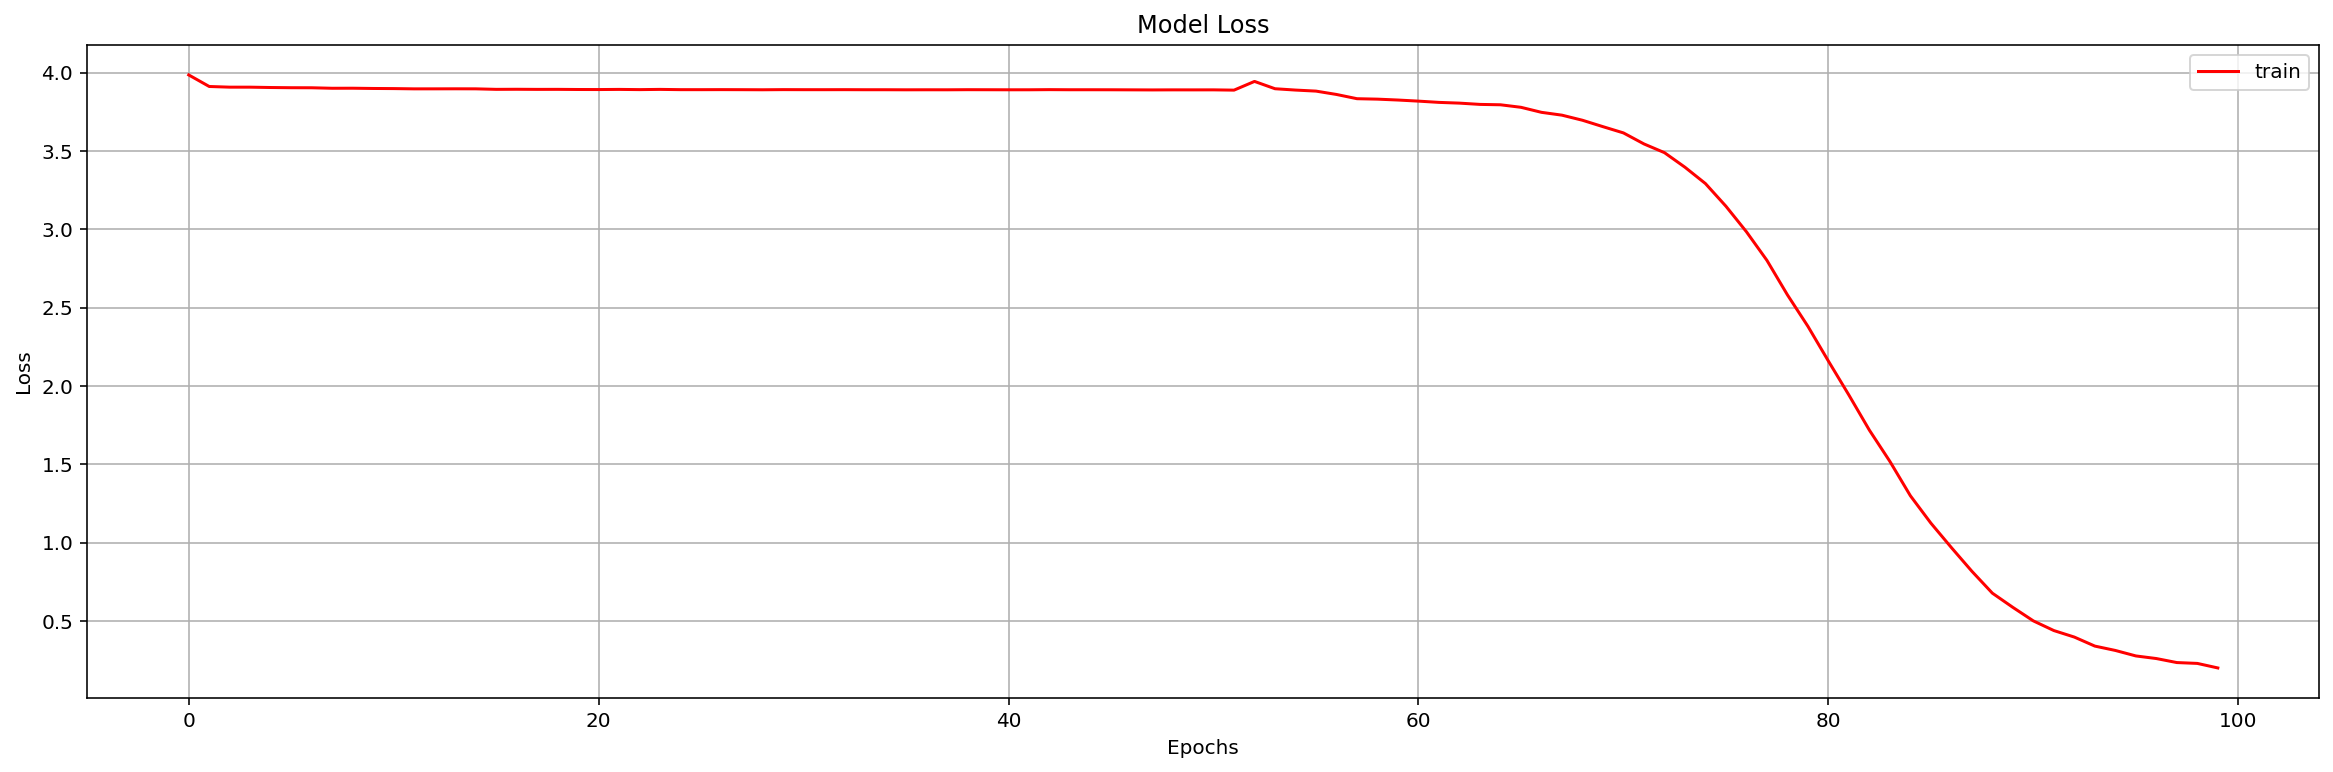

In [ ]:
# Plot the Loss Curves
plt.figure(figsize=(20,6))
plt.plot(history_3.history['loss'],'r')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()

In [ ]:
def Malody_Generator_3(Note_Count):
    # Note_Count = Count of Notes want to generate
    seed = [np.random.randint(0,len(X_test_2)-1, seq_lenght)] #sequence_length = 40
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = np.array(seed).reshape(1,seq_lenght,1)
        prediction = model_3.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(Len_symbol_2)  # L_symb is length of total unique characters
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated] # reverse_mapping is a dictionary that maps each number to its related note 
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi

Music_notes, Melody = Malody_Generator_3(50)
#To save the generated melody
Melody.write('midi','Melody_Generated_Mozart.mid')

'Melody_Generated_Mozart.mid'

In [ ]:
#Initialising the Model
model_4 = Sequential()
#Adding layers
model_4.add(LSTM(512, input_shape=(X_2.shape[1], X_2.shape[2]), return_sequences=True))
model_4.add(Dropout(0.1))
model_4.add(LSTM(256))
model_4.add(Dense(256))
model_4.add(Dropout(0.1))
model_4.add(Dense(Y_2.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model_4.compile(loss='categorical_crossentropy', optimizer=opt)

In [ ]:
model_4.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 512)           1052672   
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_3 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 140)               35980     
                                                                 
Total params: 1,941,900
Trainable params: 1,941,900
No

In [ ]:
history4 = model_4.fit(X_train_2, y_train_2, batch_size=256, epochs=Epochs) # It takes 30 min

Epoch 1/100
179/179 [==============================] - 25s 120ms/step - loss: 3.9742
Epoch 2/100
179/179 [==============================] - 22s 121ms/step - loss: 3.9064
Epoch 3/100
179/179 [==============================] - 21s 120ms/step - loss: 3.9037
Epoch 4/100
179/179 [==============================] - 21s 120ms/step - loss: 3.9014
Epoch 5/100
179/179 [==============================] - 21s 120ms/step - loss: 3.8989
Epoch 6/100
179/179 [==============================] - 21s 120ms/step - loss: 3.8994
Epoch 7/100
179/179 [==============================] - 21s 120ms/step - loss: 3.8970
Epoch 8/100
179/179 [==============================] - 21s 120ms/step - loss: 3.8979
Epoch 9/100
179/179 [==============================] - 21s 120ms/step - loss: 3.8974
Epoch 10/100
179/179 [==============================] - 22s 120ms/step - loss: 3.8964
Epoch 11/100
179/179 [==============================] - 21s 119ms/step - loss: 3.8972
Epoch 12/100
179/179 [==============================] - 21s 120

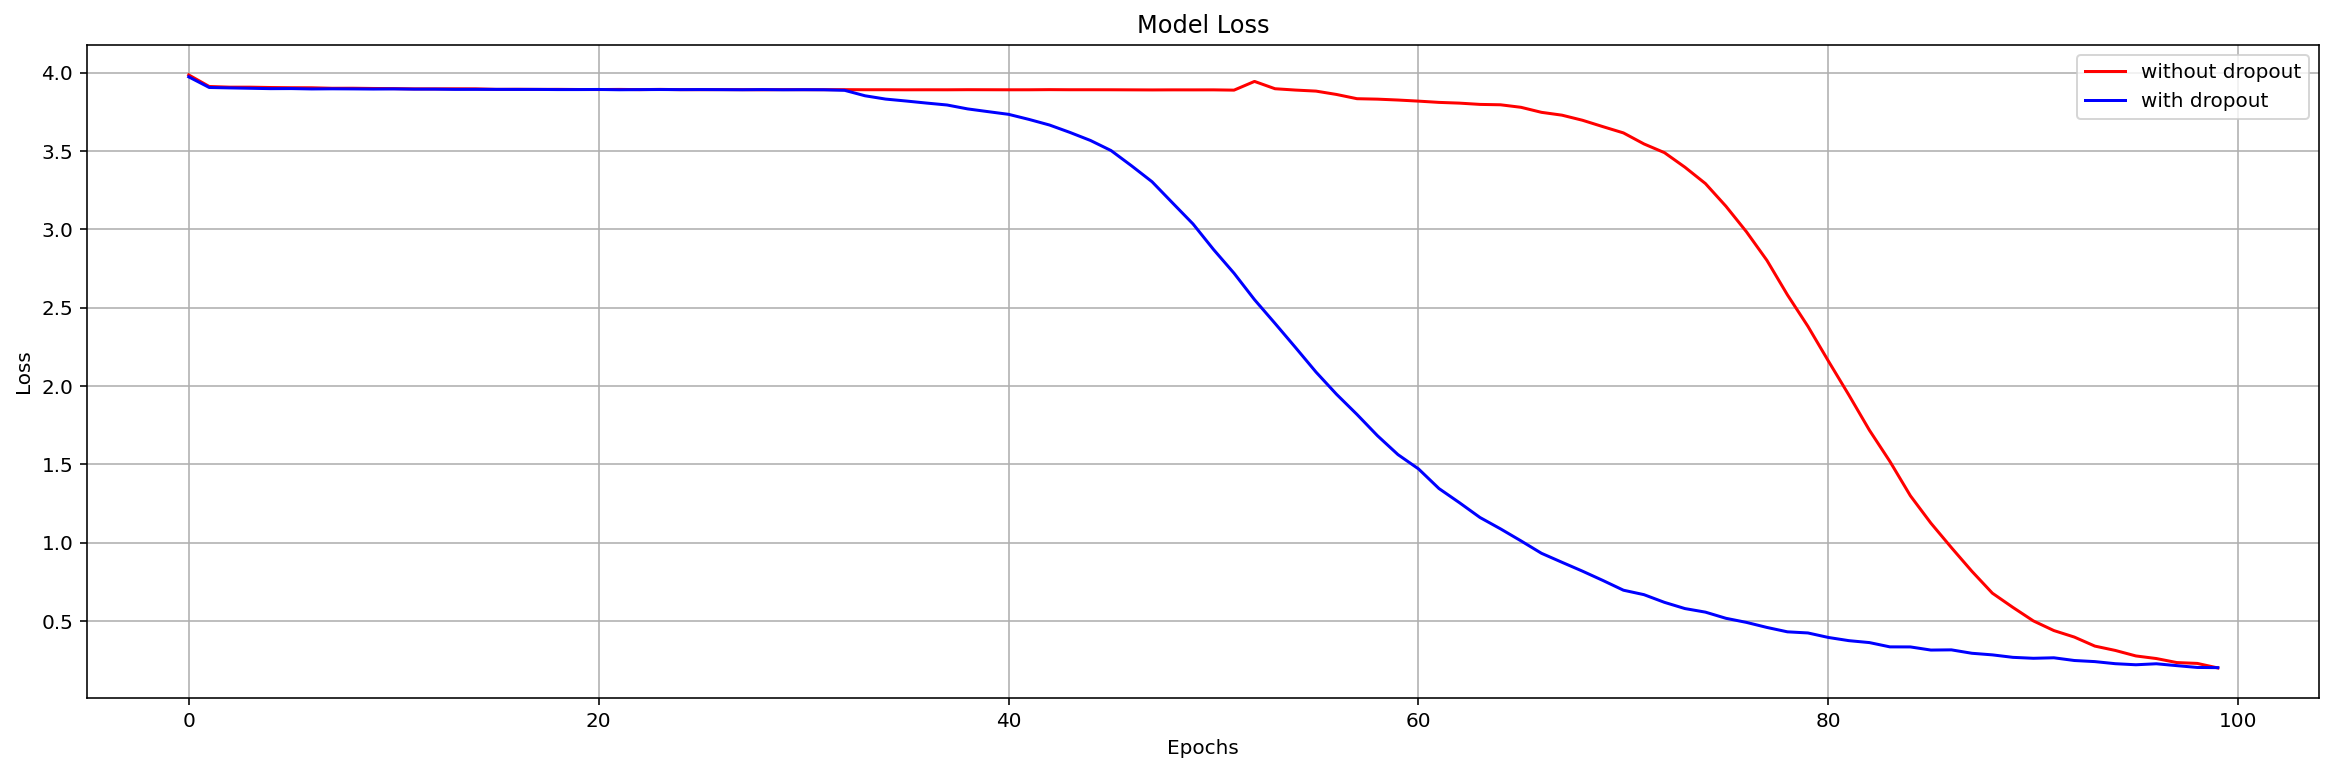

In [ ]:
# Plot the Loss Curves
plt.figure(figsize=(20,6))
plt.plot(history_3.history['loss'],'r')
plt.plot(history4.history['loss'],'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['without dropout', 'with dropout'], loc='upper right')
plt.grid()

In [ ]:
def Malody_Generator_4(Note_Count):
    # Note_Count = Count of Notes want to generate
    seed = [np.random.randint(0,len(X_test_2)-1, seq_lenght)] #sequence_length = 40
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = np.array(seed).reshape(1,seq_lenght,1)
        prediction = model_4.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(Len_symbol_2)  # L_symb is length of total unique characters
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated] # reverse_mapping is a dictionary that maps each number to its related note 
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi

Music_notes, Melody = Malody_Generator_4(50)
#To save the generated melody
Melody.write('midi','Melody_Generated_Mozart_dropout.mid')

'Melody_Generated_Mozart_dropout.mid'